In [327]:
import sys
import os
import keras
from keras.models import Model
from keras.callbacks import EarlyStopping
import math
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Activation
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.models import Sequential
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU

In [243]:
def MAPE(y_true, y_pred):
    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape


In [244]:
def process_data(train, test, lags):

    scaler = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))
    #scaler = StandardScaler().fit(train.reshape(-1, 1))
    #scaler = RobustScaler().fit(train.reshape(-1, 1))
    flow1 = scaler.transform(train.reshape(-1, 1)).reshape(1, -1)[0]
    flow2 = scaler.transform(test.reshape(-1, 1)).reshape(1, -1)[0]
    

    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    test = np.array(test)
    #np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    return X_train, y_train, X_test, y_test, scaler

In [245]:
df = pd.read_csv('data/2018_1hourdata.csv')
X = df['EASH_WASH_in'].values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
lag = 24
X_train, y_train, X_test, y_test, scaler = process_data(train, test, lag)

In [190]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6984, 24) (6984,) (1728, 24) (1728,)


In [246]:
X_train1 = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_train1.shape

(6984, 1, 24)

# Simple RNN

In [370]:
model = tf.keras.Sequential()
model.add(SimpleRNN(4, input_shape=(1, lag)))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
hist=model.fit(X_train1, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=0)

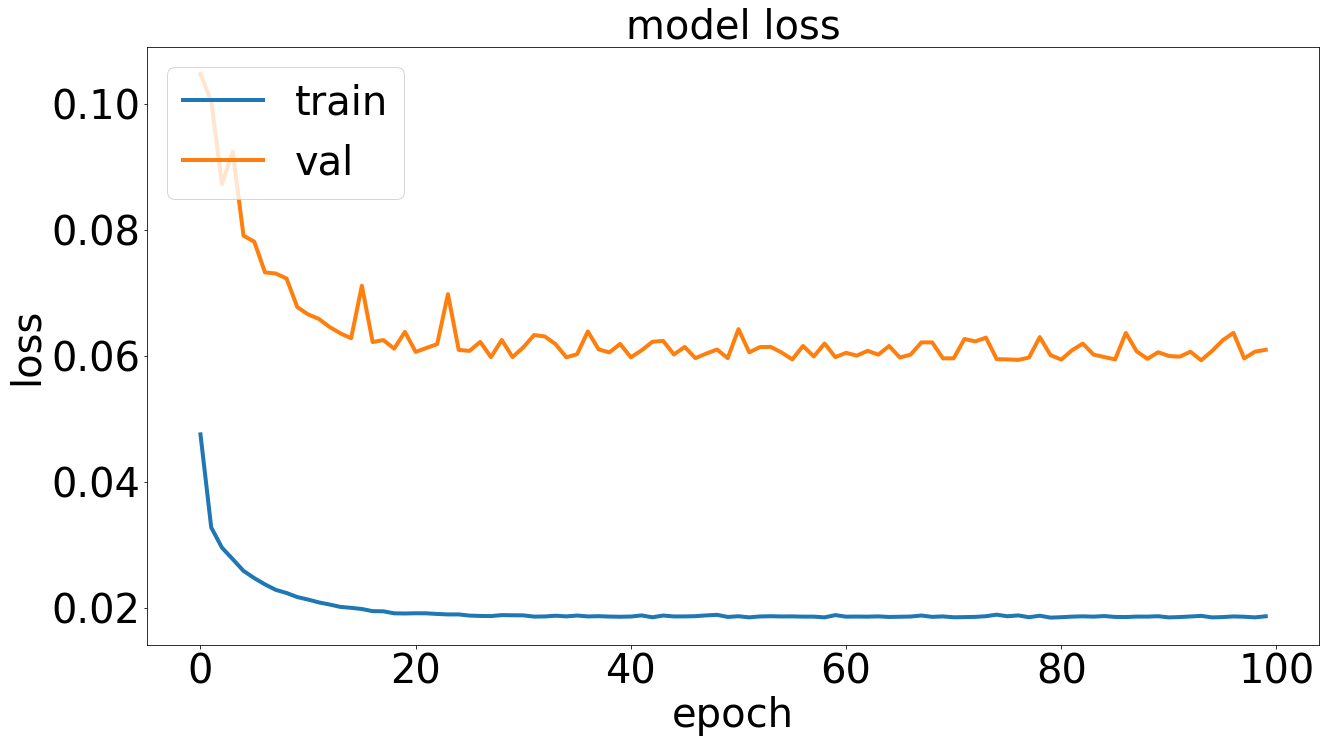

In [371]:
plt.figure(figsize=(21, 11))
plt.plot(hist.history['loss'], linewidth=4)
plt.plot(hist.history['val_loss'], linewidth=4)
plt.title('model loss', fontsize=40)
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.ylabel('loss', fontsize=40)
plt.xlabel('epoch', fontsize=40)
plt.legend(['train', 'val'], loc='upper left', fontsize=40)
plt.show()

In [372]:
i = 0
lag = 24
y = []
while i + lag <= len(y_test):
    y_i = y_test[i: i + lag]
    y.append(y_i)
    i = i + 1
y = np.stack(y, axis=0)

In [ ]:
list1 = list(map(str, list(range(1,lag + 1))))
df_obs = pd.DataFrame(columns=list1)
df_pred = pd.DataFrame(columns=list1)
df_error = pd.DataFrame(columns=['mae', 'rmse', 'mse', 'r2', 'mape'])
horizon = 24

for i in range(X_test.shape[0] - horizon): # range(0,3):    
    pred = []
    test = np.reshape(X_test[i, None], (1, 1, lag))
    model.fit(test, y_test[i, None], batch_size=1, epochs=1, validation_split=0.0)
    
    test = np.reshape(X_test[i, None], (1,1, lag))
    output = model.predict(test)
    test = np.reshape(np.append(test, output[0][0])[1:], (1, 1, lag))
    #output = scaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0]
    pred.append(output[0])
    for j in range(0,horizon - 1):
        output = model.predict(test)
        test = np.reshape(np.append(test, output[0][0])[1:], (1, 1, lag))
        #output = scaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0]
        pred.append(output[0])
    yobs = y[i]
    #yobs = scaler.inverse_transform(yobs.reshape(-1, 1))
    df_pred = df_pred.append(dict( zip( list1, pred)), ignore_index=True)
    df_obs = df_obs.append(dict( zip( list1, yobs)), ignore_index=True)
    mae = mean_absolute_error(yobs, pred)
    rmse = np.sqrt(mean_squared_error(yobs, pred))
    mse = mean_squared_error(yobs, pred)
    r2 = r2_score(yobs, pred)
    mape = MAPE(yobs, pred)
    
    df_error = df_error.append({'mae':mae, 'rmse':rmse, 'mse':mse, 'r2':r2, 'mape':mape}, ignore_index=True)
      


1/1 [==============================] - 0s 2ms/sample - loss: 0.0464


1/1 [==============================] - 0s 2ms/sample - loss: 0.2681


1/1 [==============================] - 0s 2ms/sample - loss: 0.0492


1/1 [==============================] - 0s 2ms/sample - loss: 0.0118


1/1 [==============================] - 0s 2ms/sample - loss: 0.0067


1/1 [==============================] - 0s 2ms/sample - loss: 0.1003


1/1 [==============================] - 0s 2ms/sample - loss: 0.0980


1/1 [==============================] - 0s 2ms/sample - loss: 0.0766


1/1 [==============================] - 0s 2ms/sample - loss: 0.1633


1/1 [==============================] - 0s 2ms/sample - loss: 0.1091


1/1 [==============================] - 0s 2ms/sample - loss: 0.0046


In [ ]:
# Average error of all timestamps of the test dataset
print('MAE:', df_error["mae"].mean())
print('RMSE:', df_error["rmse"].mean())
print('MSE:', df_error["mse"].mean())
print('R2:', df_error["r2"].mean())
print('MAPE:', df_error["mape"].mean())

In [ ]:
r2_list = []
for horizon in range(24):
    yobs = df_obs.iloc[:,horizon] 
    ypred = df_pred.iloc[:,horizon]  
    r2_list.append(r2_score(yobs, ypred))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.title('Simple RNN', fontsize=40)
plt.show()

In [ ]:
mape_list = []
for horizon in range(24):
    yobs = df_obs.iloc[:,horizon] 
    ypred = df_pred.iloc[:,horizon]  
    mape_list.append(MAPE(yobs, ypred)[0])    
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,mape_list)
plt.ylabel('mape', fontsize=40)

plt.xlabel('hours', fontsize=40)
plt.title('Simple RNN', fontsize=40)
plt.show()

In [ ]:
# Horizon wise plot
plt.figure(figsize=(21, 11), dpi= 80, facecolor='w', edgecolor='k')
horizon = 1
yobs = df_obs.iloc[:,horizon] 
ypred = df_pred.iloc[:,horizon]  
print(mean_absolute_error(yobs, ypred))
print(r2_score(yobs, ypred))
plt.plot(yobs,'o-', label='input')#, linewidth=6)
plt.plot(ypred, 'o-',  label='output')#, linewidth=6)

# Vanilla LSTM

In [345]:
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, lag)))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
hist=model.fit(X_train1, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=0)

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
#hist = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.05,  callbacks=[es])


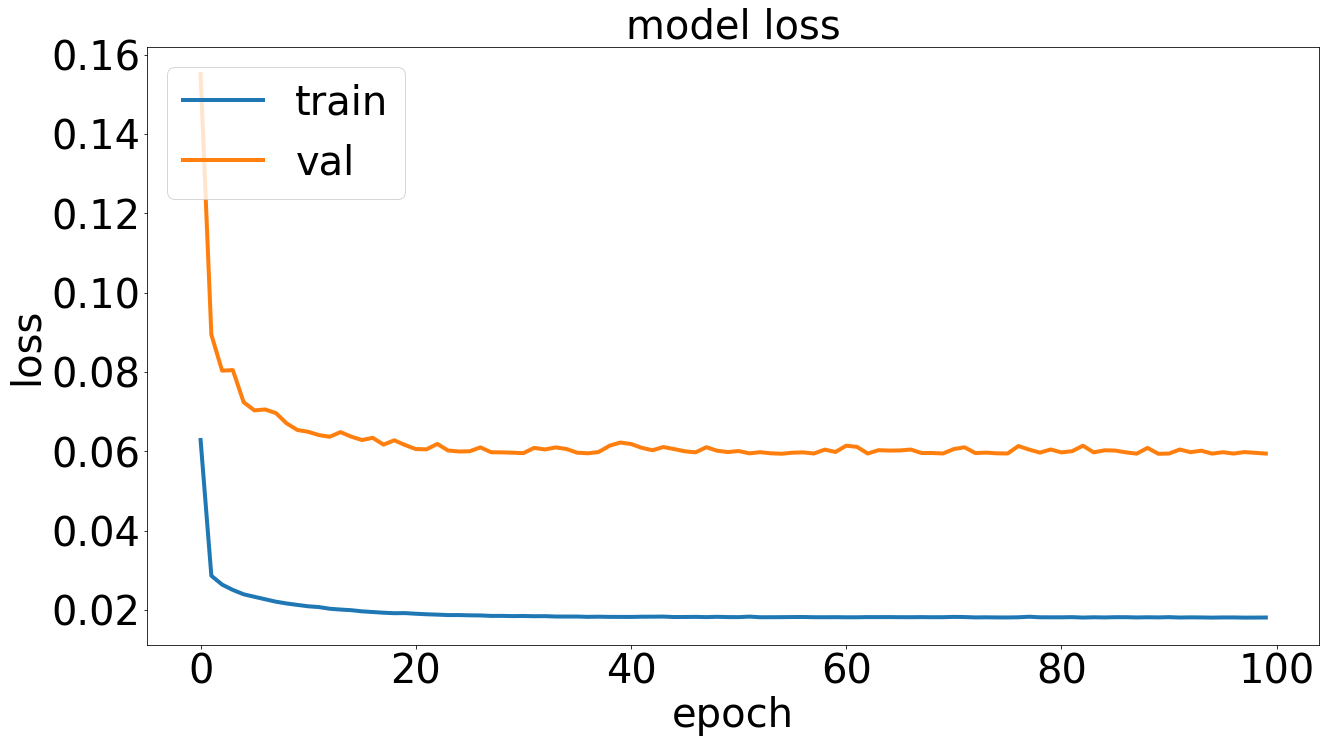

In [346]:
plt.figure(figsize=(21, 11))
plt.plot(hist.history['loss'], linewidth=4)
plt.plot(hist.history['val_loss'], linewidth=4)
plt.title('model loss', fontsize=40)
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.ylabel('loss', fontsize=40)
plt.xlabel('epoch', fontsize=40)
plt.legend(['train', 'val'], loc='upper left', fontsize=40)
plt.show()

In [347]:
i = 0
look_back = 24
y = []
while i + look_back <= len(y_test):
    y_i = y_test[i: i + look_back]
    y.append(y_i)
    i = i + 1
y = np.stack(y, axis=0)

In [348]:
list1 = list(map(str, list(range(1,lag + 1))))
df_obs = pd.DataFrame(columns=list1)
df_pred = pd.DataFrame(columns=list1)
df_error = pd.DataFrame(columns=['mae', 'rmse', 'mse', 'r2', 'mape'])
horizon = 24

for i in range(X_test.shape[0] - horizon): # range(0,3):    
    pred = []
    test = np.reshape(X_test[i, None], (1, 1, lag))
    model.fit(test, y_test[i, None], batch_size=1, epochs=1, validation_split=0.0)
    
    test = np.reshape(X_test[i, None], (1,1, lag))
    output = model.predict(test)
    test = np.reshape(np.append(test, output[0][0])[1:], (1, 1, lag))
    #output = scaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0]
    pred.append(output[0])
    for j in range(0,horizon - 1):
        output = model.predict(test)
        test = np.reshape(np.append(test, output[0][0])[1:], (1, 1, lag))
        #output = scaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0]
        pred.append(output[0])
    yobs = y[i]
    #yobs = scaler.inverse_transform(yobs.reshape(-1, 1))
    df_pred = df_pred.append(dict( zip( list1, pred)), ignore_index=True)
    df_obs = df_obs.append(dict( zip( list1, yobs)), ignore_index=True)
    mae = mean_absolute_error(yobs, pred)
    rmse = np.sqrt(mean_squared_error(yobs, pred))
    mse = mean_squared_error(yobs, pred)
    r2 = r2_score(yobs, pred)
    mape = MAPE(yobs, pred)
    
    df_error = df_error.append({'mae':mae, 'rmse':rmse, 'mse':mse, 'r2':r2, 'mape':mape}, ignore_index=True)
      


1/1 [==============================] - 0s 3ms/sample - loss: 0.0383


1/1 [==============================] - 0s 3ms/sample - loss: 0.2636


1/1 [==============================] - 0s 3ms/sample - loss: 0.0278


1/1 [==============================] - 0s 3ms/sample - loss: 7.2354e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0495


1/1 [==============================] - 0s 3ms/sample - loss: 0.0212


1/1 [==============================] - 0s 3ms/sample - loss: 0.1534


1/1 [==============================] - 0s 3ms/sample - loss: 0.0530


1/1 [==============================] - 0s 3ms/sample - loss: 0.0822


1/1 [==============================] - 0s 3ms/sample - loss: 0.0779


1/1 [==============================] - 0s 3ms/sample - loss: 0.0552


1/1 [==============================] - 0s 3ms/sample - loss: 0.0537


1/1 [==============================] - 0s 3ms/sample - loss: 0.2503


1/1 [==============================] - 0s 4ms/sample - loss: 0.0773


1/1 [==============================] - 0s 3ms/sample - loss: 0.1088


In [349]:
# Average error of all timestamps of the test dataset
print('MAE:', df_error["mae"].mean())
print('RMSE:', df_error["rmse"].mean())
print('MSE:', df_error["mse"].mean())
print('R2:', df_error["r2"].mean())
print('MAPE:', df_error["mape"].mean())

MAE: 0.21432086466020803
RMSE: 0.2509626782252315
MSE: 0.11058701319452191
R2: -19.54187400579341
MAPE: [92.144585]


0.13122335876139252


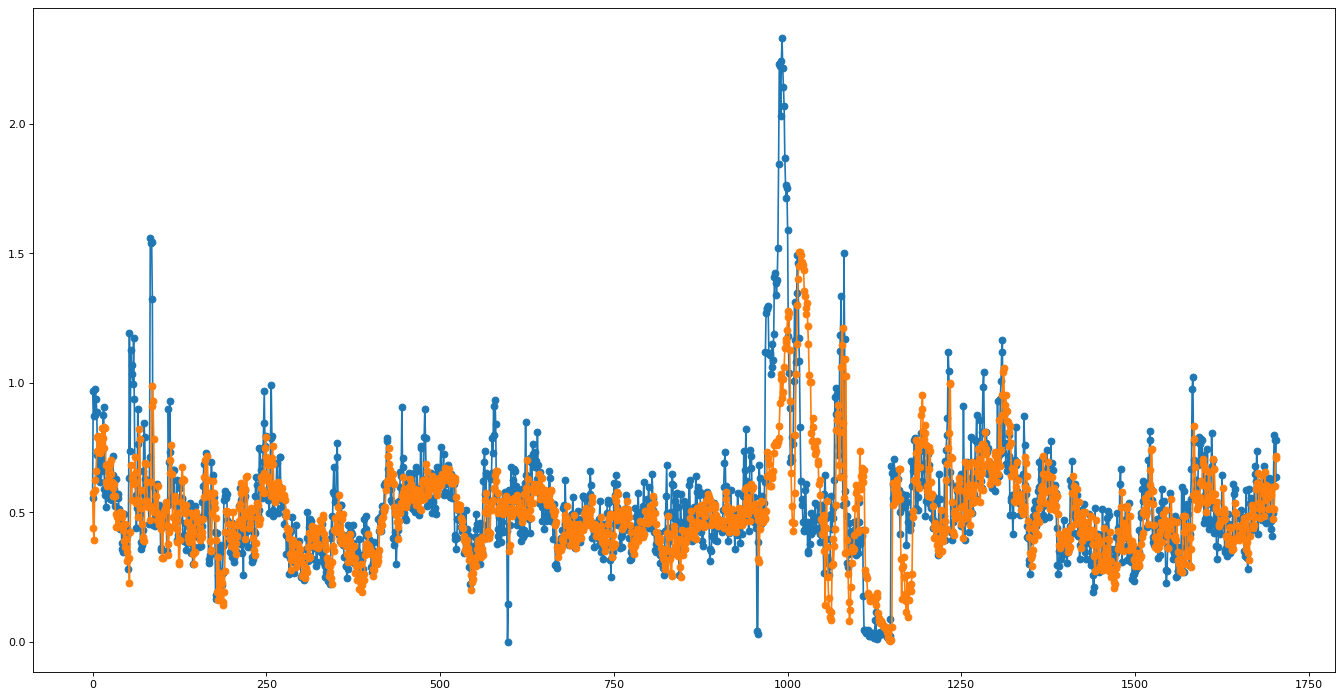

In [350]:
# Horizon wise plot
plt.figure(figsize=(21, 11), dpi= 80, facecolor='w', edgecolor='k')
horizon = 1
yobs = df_obs.iloc[:,horizon] 
ypred = df_pred.iloc[:,horizon]  
print(mean_absolute_error(yobs, ypred))
plt.plot(yobs,'o-', label='input')#, linewidth=6)
plt.plot(ypred, 'o-',  label='output')#, linewidth=6)

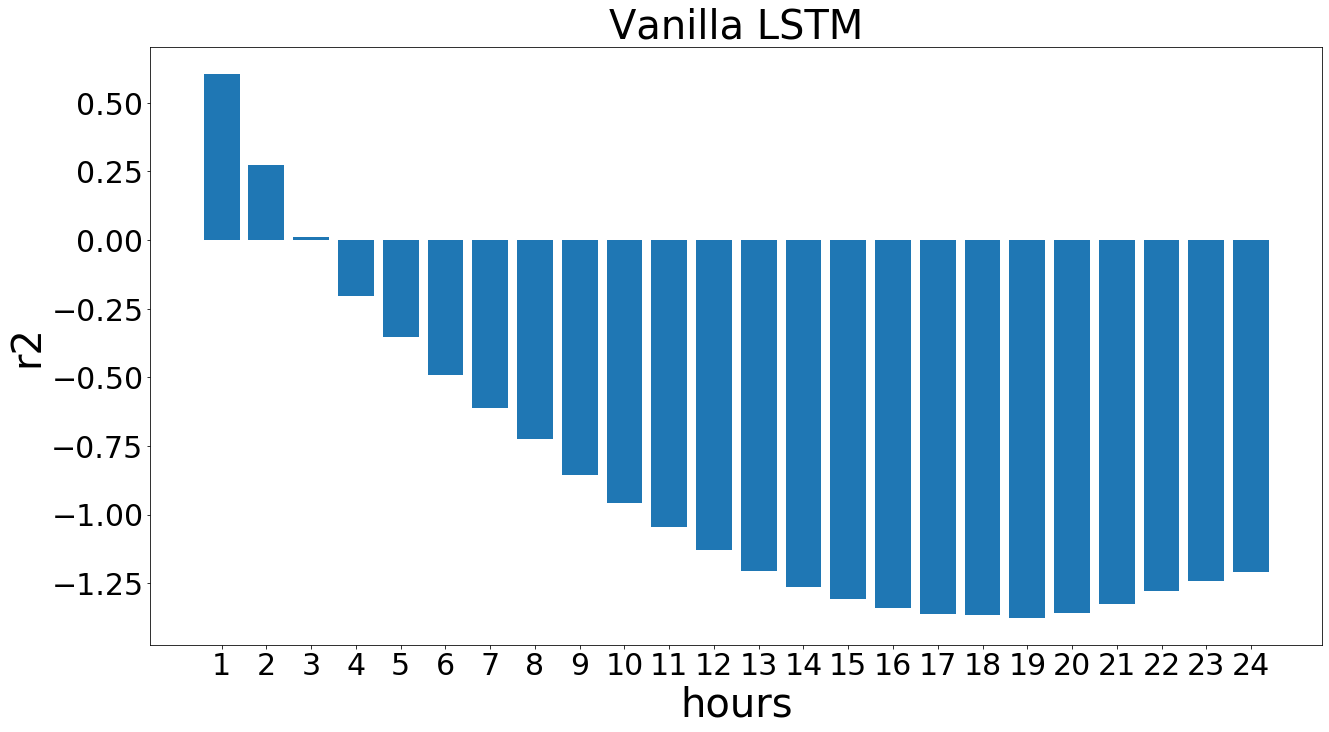

In [351]:
r2_list = []
for horizon in range(24):
    yobs = df_obs.iloc[:,horizon] 
    ypred = df_pred.iloc[:,horizon]  
    r2_list.append(r2_score(yobs, ypred))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.title('Vanilla LSTM', fontsize=40)
plt.show()

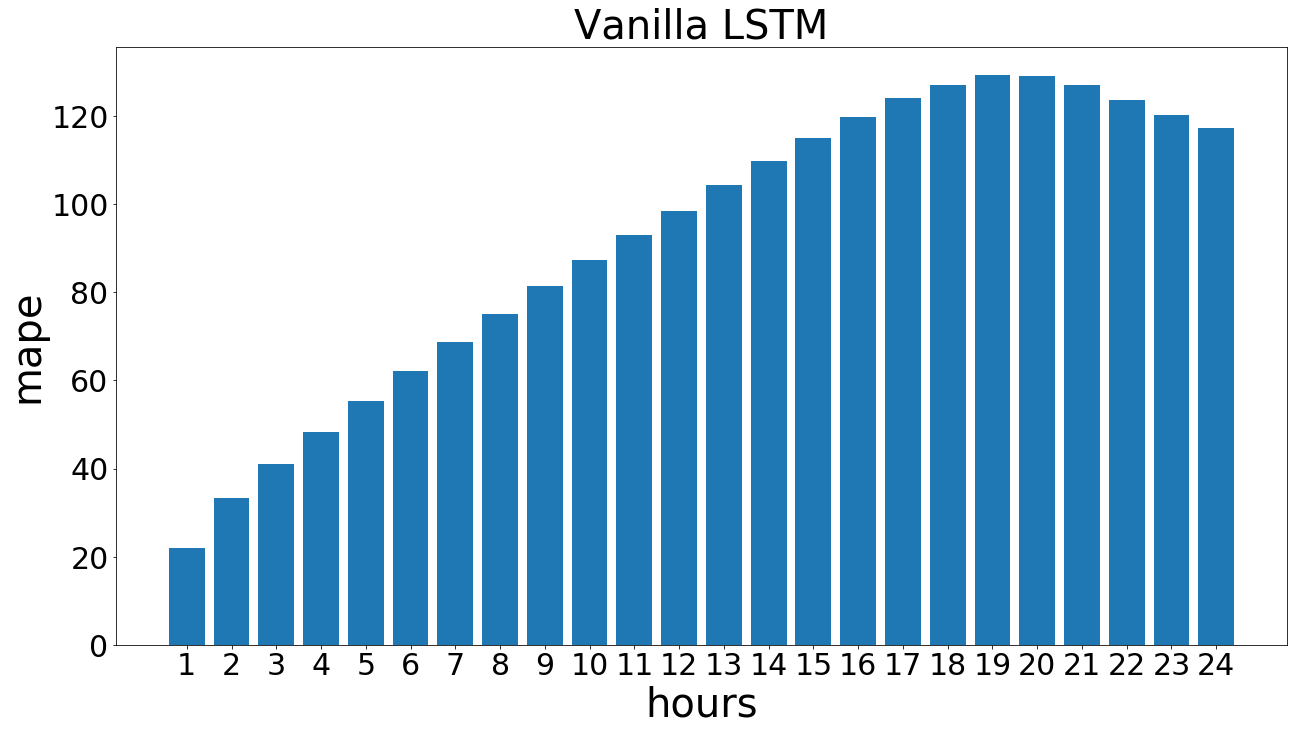

In [352]:
mape_list = []
for horizon in range(24):
    yobs = df_obs.iloc[:,horizon] 
    ypred = df_pred.iloc[:,horizon]  
    mape_list.append(MAPE(yobs, ypred)[0])
    
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,mape_list)
plt.ylabel('mape', fontsize=40)

plt.xlabel('hours', fontsize=40)
plt.title('Vanilla LSTM', fontsize=40)
plt.show()

# Stacked LSTM

In [358]:
model = tf.keras.Sequential()
model.add(LSTM(lag, input_shape=(1, lag), activation='relu', return_sequences=True))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(LSTM(256))
model.add(Dense(1, activation='relu'))

model.compile(loss='mae', optimizer='adam')
hist=model.fit(X_train1, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=0)

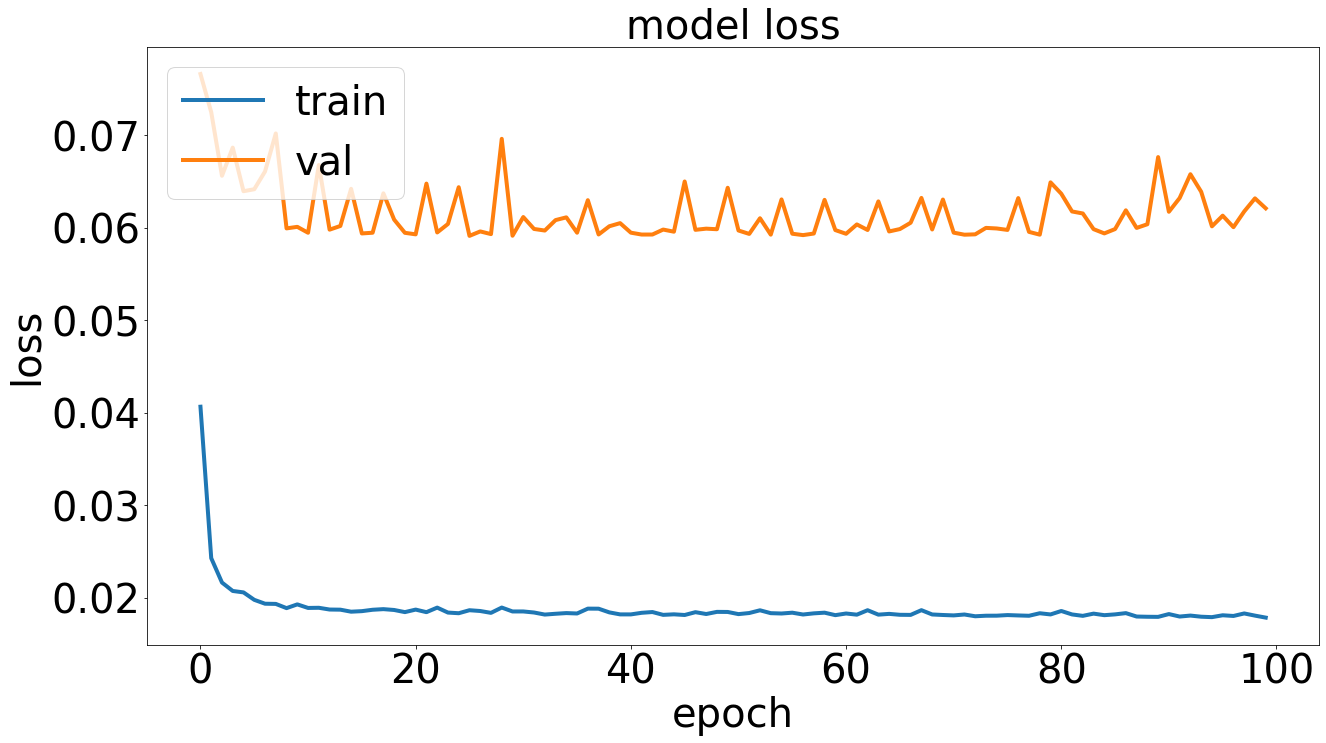

In [359]:
plt.figure(figsize=(21, 11))
plt.plot(hist.history['loss'], linewidth=4)
plt.plot(hist.history['val_loss'], linewidth=4)
plt.title('model loss', fontsize=40)
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.ylabel('loss', fontsize=40)
plt.xlabel('epoch', fontsize=40)
plt.legend(['train', 'val'], loc='upper left', fontsize=40)
plt.show()

In [360]:
i = 0
look_back = 24
y = []
while i + look_back <= len(y_test):
    y_i = y_test[i: i + look_back]
    y.append(y_i)
    i = i + 1
y = np.stack(y, axis=0)

list1 = list(map(str, list(range(1,lag + 1))))
df_obs = pd.DataFrame(columns=list1)
df_pred = pd.DataFrame(columns=list1)
df_error = pd.DataFrame(columns=['mae', 'rmse', 'mse', 'r2', 'mape'])
horizon = 24

for i in range(X_test.shape[0] - horizon): # range(0,3):    
    pred = []
    test = np.reshape(X_test[i, None], (1, 1, lag))
    model.fit(test, y_test[i, None], batch_size=1, epochs=1, validation_split=0.0)
    
    test = np.reshape(X_test[i, None], (1,1, lag))
    output = model.predict(test)
    test = np.reshape(np.append(test, output[0][0])[1:], (1, 1, lag))
    #output = scaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0]
    pred.append(output[0])
    for j in range(0,horizon - 1):
        output = model.predict(test)
        test = np.reshape(np.append(test, output[0][0])[1:], (1, 1, lag))
        #output = scaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0]
        pred.append(output[0])
    yobs = y[i]
    #yobs = scaler.inverse_transform(yobs.reshape(-1, 1))
    df_pred = df_pred.append(dict( zip( list1, pred)), ignore_index=True)
    df_obs = df_obs.append(dict( zip( list1, yobs)), ignore_index=True)
    mae = mean_absolute_error(yobs, pred)
    rmse = np.sqrt(mean_squared_error(yobs, pred))
    mse = mean_squared_error(yobs, pred)
    r2 = r2_score(yobs, pred)
    mape = MAPE(yobs, pred)
    
    df_error = df_error.append({'mae':mae, 'rmse':rmse, 'mse':mse, 'r2':r2, 'mape':mape}, ignore_index=True)
      


1/1 [==============================] - 0s 14ms/sample - loss: 0.1930


1/1 [==============================] - 0s 14ms/sample - loss: 0.0036


1/1 [==============================] - 0s 9ms/sample - loss: 0.2174


1/1 [==============================] - 0s 10ms/sample - loss: 0.2252


1/1 [==============================] - 0s 10ms/sample - loss: 0.5492


1/1 [==============================] - 0s 12ms/sample - loss: 0.1255


1/1 [==============================] - 0s 10ms/sample - loss: 0.1607


1/1 [==============================] - 0s 14ms/sample - loss: 0.0089


1/1 [==============================] - 0s 11ms/sample - loss: 0.1587


1/1 [==============================] - 0s 13ms/sample - loss: 0.1713


1/1 [==============================] - 0s 10ms/sample - loss: 0.0279


1/1 [==============================] - 0s 12ms/sample - loss: 0.0367


1/1 [==============================] - 0s 10ms/sample - loss: 0.0462


1/1 [==============================] - 0s 10ms/sample - loss: 0.0210


1/1 [==============================] - 0s 10ms/sample - loss: 0.0474


In [361]:
# Average error of all timestamps of the test dataset
print('MAE:', df_error["mae"].mean())
print('RMSE:', df_error["rmse"].mean())
print('MSE:', df_error["mse"].mean())
print('R2:', df_error["r2"].mean())
print('MAPE:', df_error["mape"].mean())

MAE: 0.1843886058636767
RMSE: 0.21721672161137998
MSE: 0.07987944688968682
R2: -5.460594054015012
MAPE: [58.2037]


0.13350827191165124


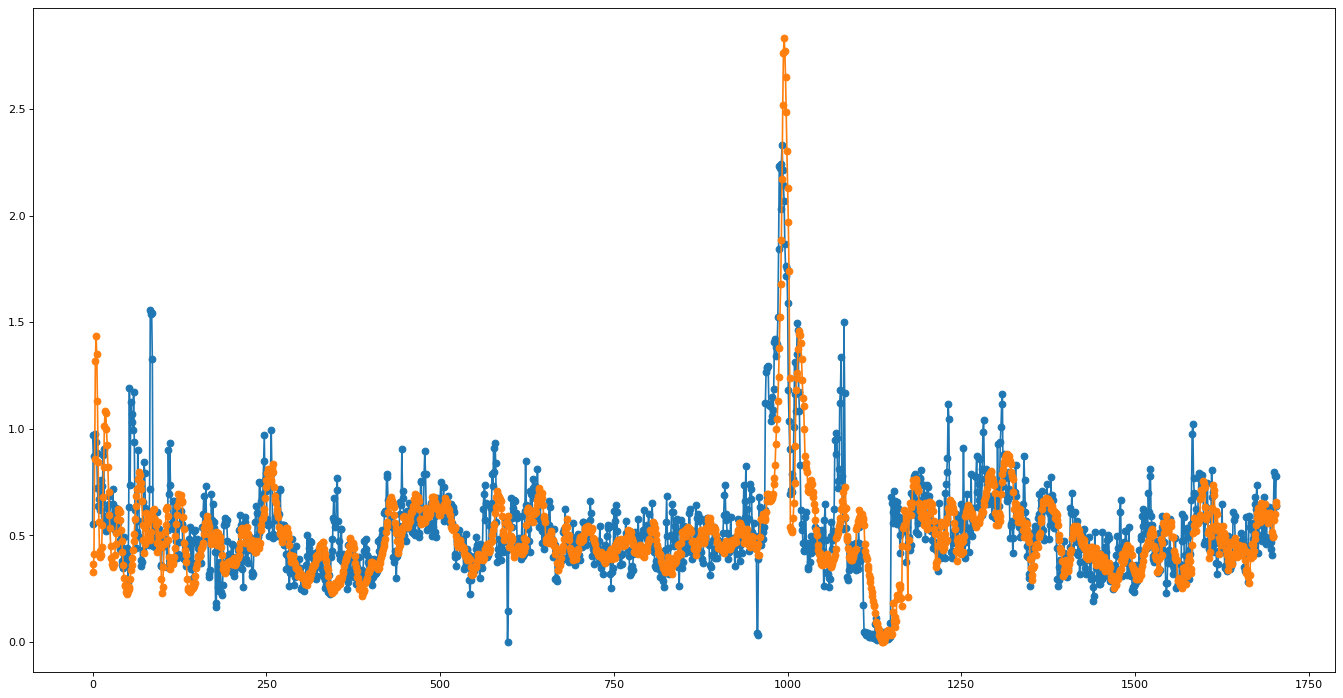

In [362]:
# Horizon wise plot
plt.figure(figsize=(21, 11), dpi= 80, facecolor='w', edgecolor='k')
horizon = 1
yobs = df_obs.iloc[:,horizon] 
ypred = df_pred.iloc[:,horizon]  
print(mean_absolute_error(yobs, ypred))
plt.plot(yobs,'o-', label='input')#, linewidth=6)
plt.plot(ypred, 'o-',  label='output')#, linewidth=6)

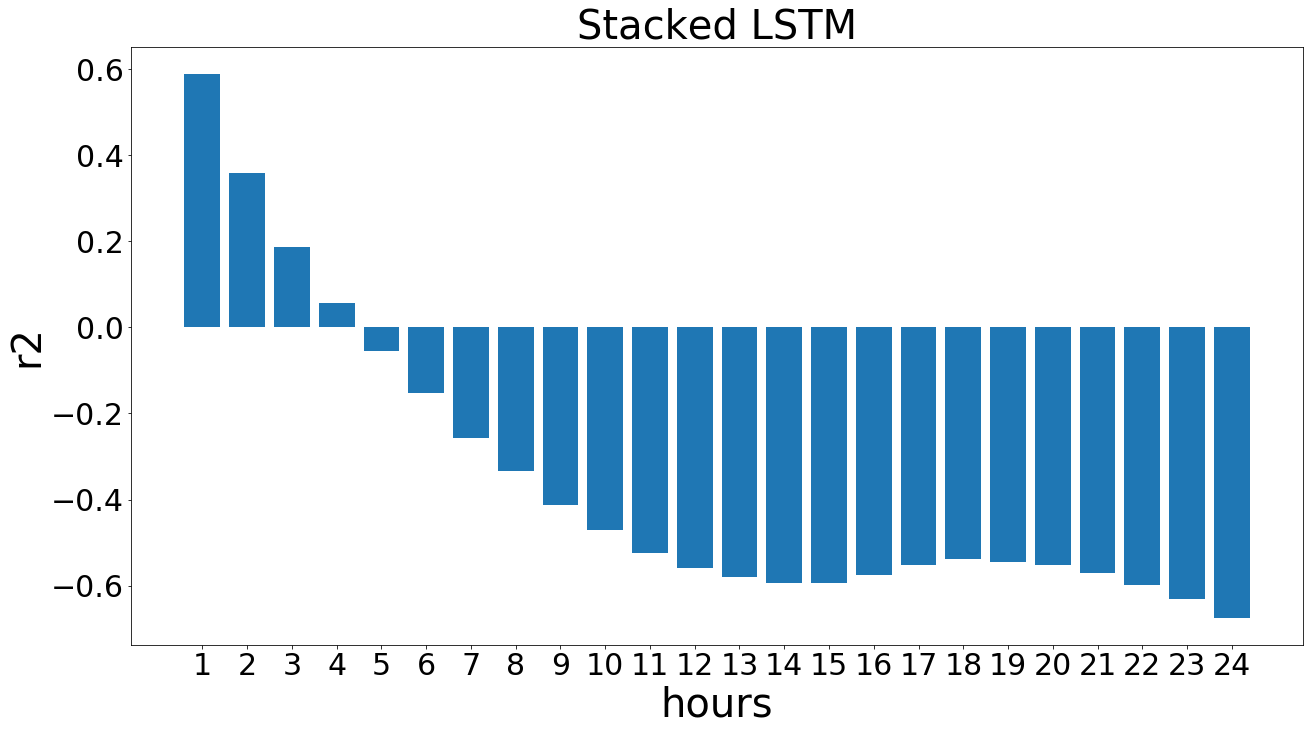

In [363]:
r2_list = []
for horizon in range(24):
    yobs = df_obs.iloc[:,horizon] 
    ypred = df_pred.iloc[:,horizon]  
    r2_list.append(r2_score(yobs, ypred))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.title('Stacked LSTM', fontsize=40)
plt.show()

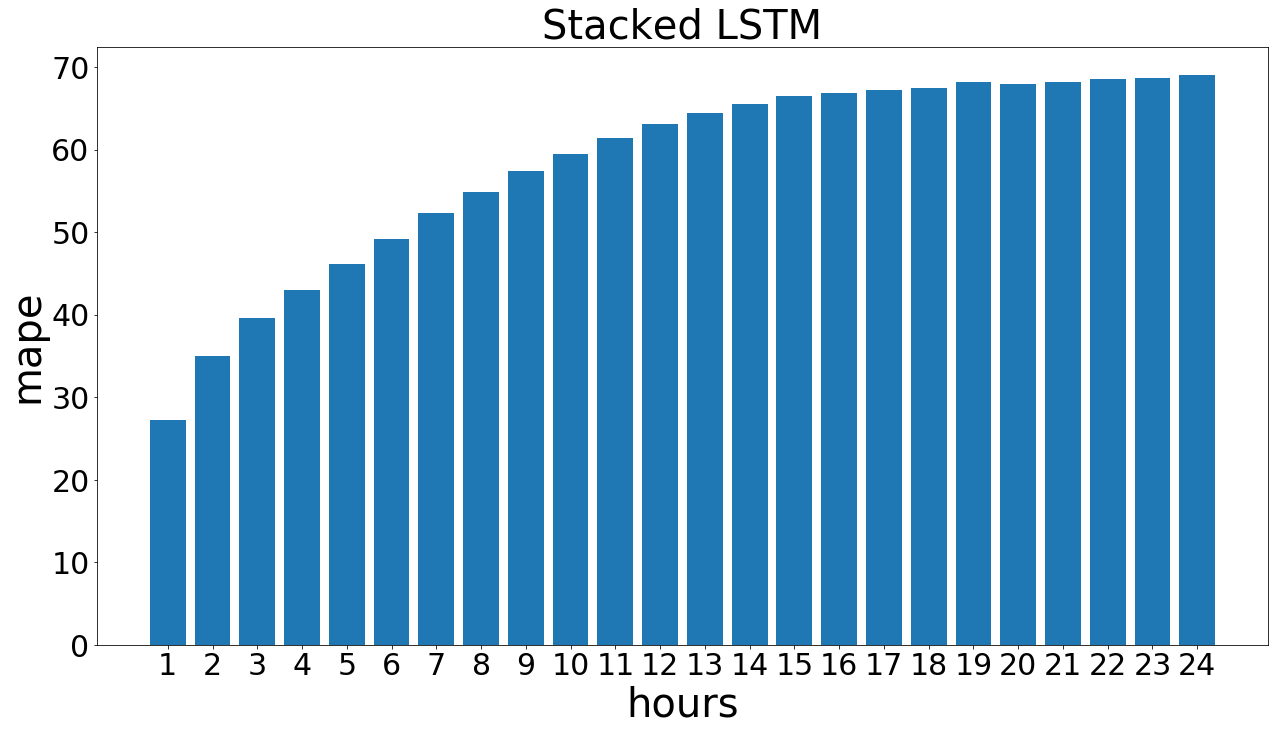

In [364]:
mape_list = []
for horizon in range(24):
    yobs = df_obs.iloc[:,horizon] 
    ypred = df_pred.iloc[:,horizon]  
    mape_list.append(MAPE(yobs, ypred)[0])
    
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,mape_list)
plt.ylabel('mape', fontsize=40)

plt.xlabel('hours', fontsize=40)
plt.title('Stacked LSTM', fontsize=40)
plt.show()

# GRU

In [328]:
model = tf.keras.Sequential()
model.add(GRU(4, input_shape=(1, lag)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
hist=model.fit(X_train1, y_train, validation_split=0.2, epochs=100, batch_size=64, verbose=0)

Instructions for updating:
Use tf.cast instead.


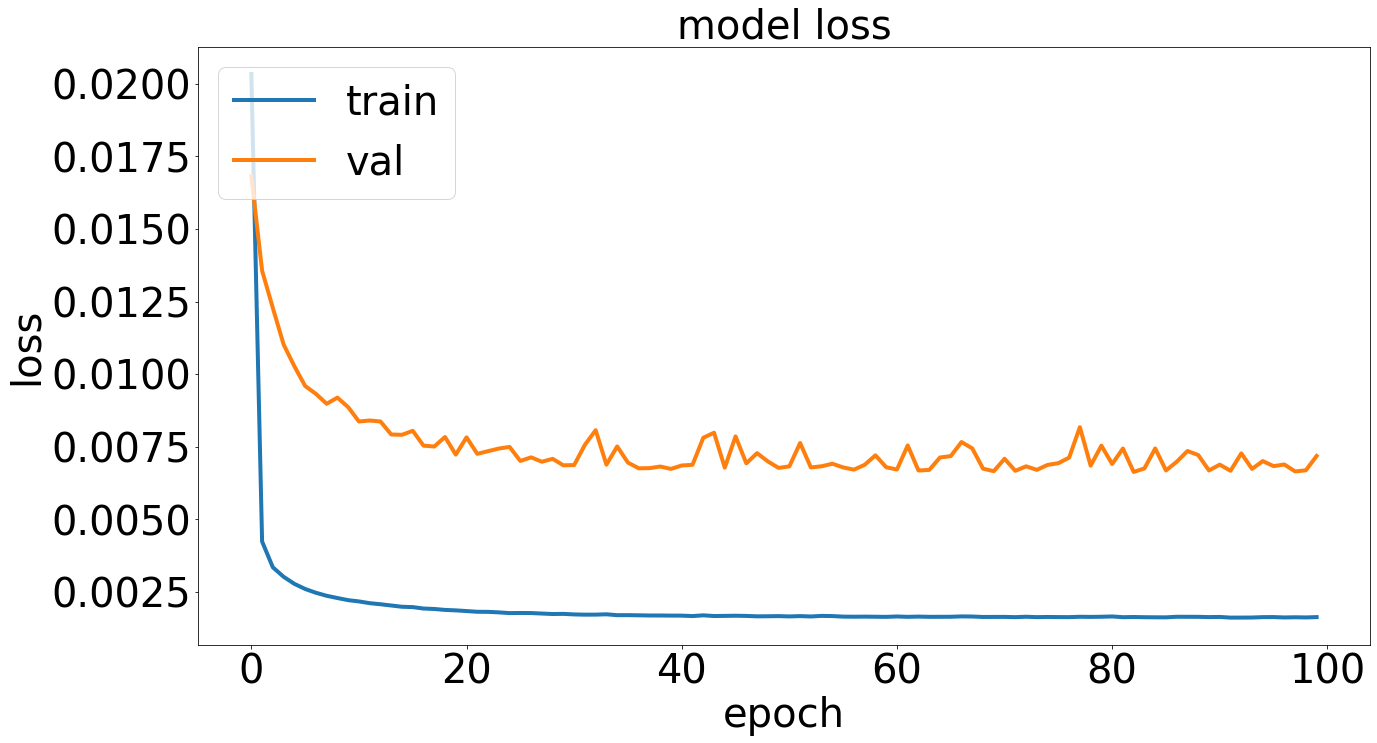

In [329]:
plt.figure(figsize=(21, 11))
plt.plot(hist.history['loss'], linewidth=4)
plt.plot(hist.history['val_loss'], linewidth=4)
plt.title('model loss', fontsize=40)
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.ylabel('loss', fontsize=40)
plt.xlabel('epoch', fontsize=40)
plt.legend(['train', 'val'], loc='upper left', fontsize=40)
plt.show()

In [330]:
i = 0
look_back = 24
y = []
while i + look_back <= len(y_test):
    y_i = y_test[i: i + look_back]
    y.append(y_i)
    i = i + 1
y = np.stack(y, axis=0)

list1 = list(map(str, list(range(1,lag + 1))))
df_obs = pd.DataFrame(columns=list1)
df_pred = pd.DataFrame(columns=list1)
df_error = pd.DataFrame(columns=['mae', 'rmse', 'mse', 'r2', 'mape'])
horizon = 24

for i in range(X_test.shape[0] - horizon): # range(0,3):    
    pred = []
    test = np.reshape(X_test[i, None], (1, 1, lag))
    model.fit(test, y_test[i, None], batch_size=1, epochs=1, validation_split=0.0)
    
    test = np.reshape(X_test[i, None], (1,1, lag))
    output = model.predict(test)
    test = np.reshape(np.append(test, output[0][0])[1:], (1, 1, lag))
    #output = scaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0]
    pred.append(output[0])
    for j in range(0,horizon - 1):
        output = model.predict(test)
        test = np.reshape(np.append(test, output[0][0])[1:], (1, 1, lag))
        #output = scaler.inverse_transform(output.reshape(-1, 1)).reshape(1, -1)[0]
        pred.append(output[0])
    yobs = y[i]
    #yobs = scaler.inverse_transform(yobs.reshape(-1, 1))
    df_pred = df_pred.append(dict( zip( list1, pred)), ignore_index=True)
    df_obs = df_obs.append(dict( zip( list1, yobs)), ignore_index=True)
    mae = mean_absolute_error(yobs, pred)
    rmse = np.sqrt(mean_squared_error(yobs, pred))
    mse = mean_squared_error(yobs, pred)
    r2 = r2_score(yobs, pred)
    mape = MAPE(yobs, pred)
    
    df_error = df_error.append({'mae':mae, 'rmse':rmse, 'mse':mse, 'r2':r2, 'mape':mape}, ignore_index=True)
      


1/1 [==============================] - 0s 2ms/sample - loss: 0.0105


1/1 [==============================] - 0s 3ms/sample - loss: 5.5485e-05


1/1 [==============================] - 0s 2ms/sample - loss: 0.0013


1/1 [==============================] - 0s 3ms/sample - loss: 0.0109


1/1 [==============================] - 0s 3ms/sample - loss: 0.0014


1/1 [==============================] - 0s 3ms/sample - loss: 0.0106


1/1 [==============================] - 0s 3ms/sample - loss: 0.0085


1/1 [==============================] - 0s 3ms/sample - loss: 0.0203


1/1 [==============================] - 0s 3ms/sample - loss: 0.0050


1/1 [==============================] - 0s 3ms/sample - loss: 3.8226e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0415


1/1 [==============================] - 0s 3ms/sample - loss: 0.0107


1/1 [==============================] - 0s 3ms/sample - loss: 2.3945e-04


1/1 [==============================] - 0s 3ms/sample - loss: 9.4638e-04


1/1 [==============================] - 0s 3ms/sample - loss: 0.0056


In [331]:
# Average error of all timestamps of the test dataset
print('MAE:', df_error["mae"].mean())
print('RMSE:', df_error["rmse"].mean())
print('MSE:', df_error["mse"].mean())
print('R2:', df_error["r2"].mean())
print('MAPE:', df_error["mape"].mean())

MAE: 0.19833739407063264
RMSE: 0.23405069538231615
MSE: 0.09833881653971928
R2: -20.556928857371506
MAPE: [94.71425]


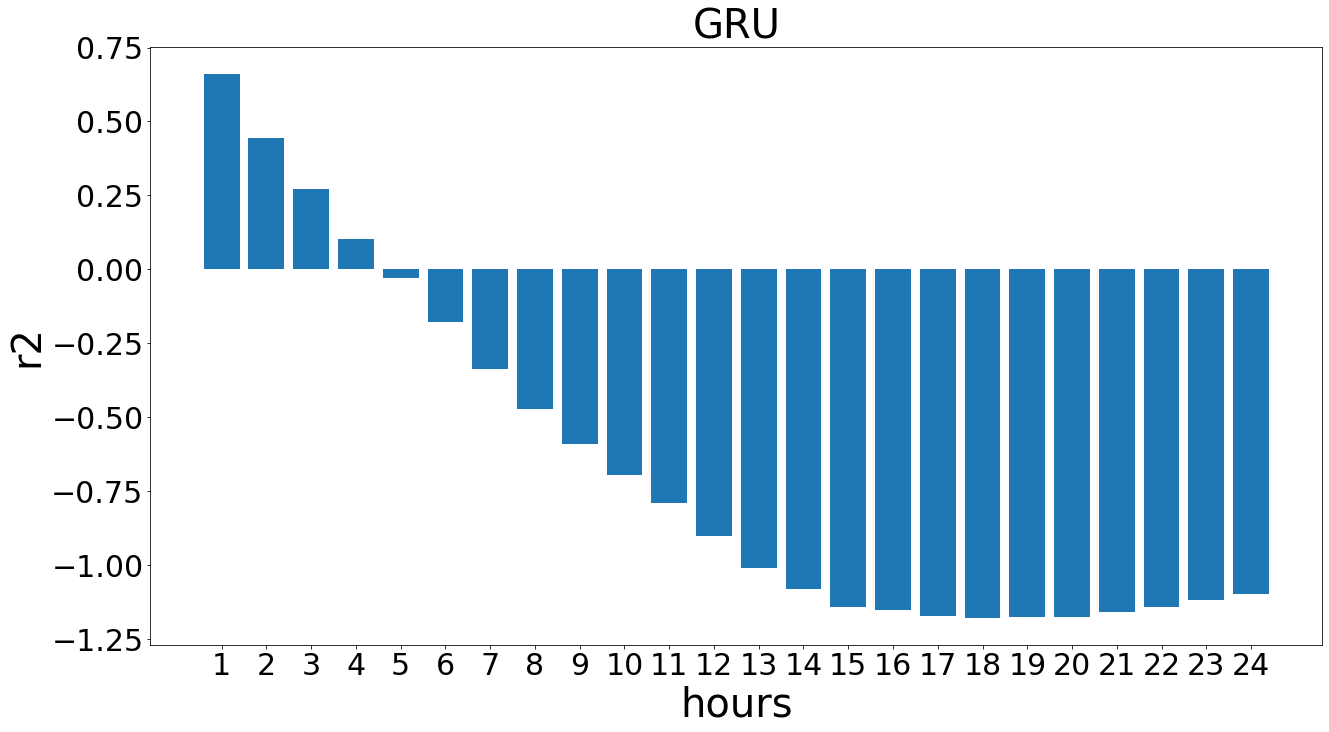

In [333]:
r2_list = []
for horizon in range(24):
    yobs = df_obs.iloc[:,horizon] 
    ypred = df_pred.iloc[:,horizon]  
    r2_list.append(r2_score(yobs, ypred))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.title('GRU', fontsize=40)
plt.show()

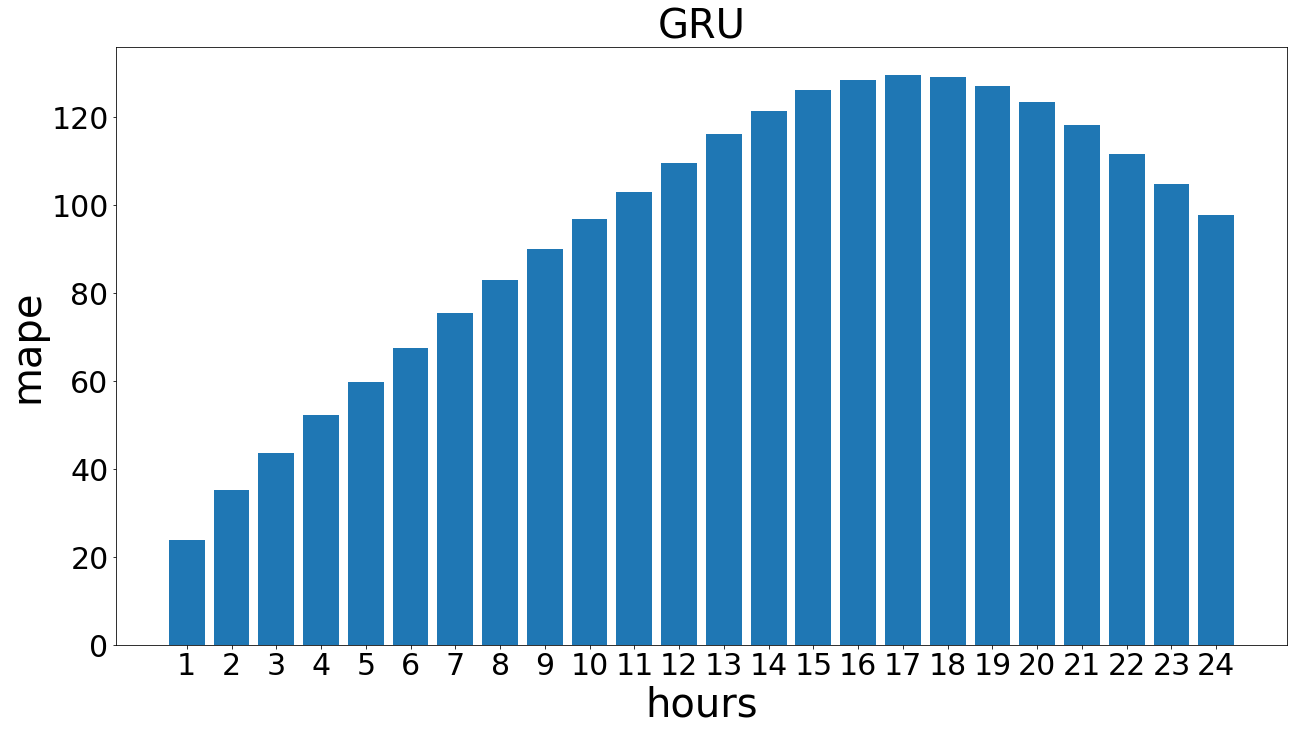

In [334]:
mape_list = []
for horizon in range(24):
    yobs = df_obs.iloc[:,horizon] 
    ypred = df_pred.iloc[:,horizon]  
    mape_list.append(MAPE(yobs, ypred)[0])
    
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,mape_list)
plt.ylabel('mape', fontsize=40)

plt.xlabel('hours', fontsize=40)
plt.title('GRU', fontsize=40)
plt.show()

# ARIMA

In [77]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

look_back = 24
shift = 1
df = pd.read_csv('data/2018_1hourdata.csv')
X = df['EASH_WASH_in'].values

size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

scaler = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))
#scaler = StandardScaler().fit(train.reshape(-1, 1))
#scaler = RobustScaler().fit(train.reshape(-1, 1))
train = scaler.transform(train.reshape(-1, 1)).reshape(1, -1)[0]
test = scaler.transform(test.reshape(-1, 1)).reshape(1, -1)[0]

x_test, y_test = [], []
i = 0
while i + 1 + (2* look_back) <= len(test):
    x_i = test[i: i + look_back]
    y_i = test[i + shift + look_back: i + shift + (2* look_back)]
    x_test.append(x_i)
    y_test.append(y_i)
    i = i + 1
x_test = np.stack(x_test, axis=0)
y_test = np.stack(y_test, axis=0)

In [91]:
list1 = list(map(str, list(range(1,25))))

#model = ARIMA(train, order=(1,0,0)) # (2, 1, 2)
#model_fit = model.fit(disp=0)

df_obs = pd.DataFrame(columns=list1)
df_pred = pd.DataFrame(columns=list1)
df_error = pd.DataFrame(columns=['mae', 'rmse', 'mse', 'r2', 'mape'])

for i in range(x_test.shape[0]):
    history = x_test[i]
    model = ARIMA(history, order=(1,0,0)) # (2, 1, 2)
    model_fit = model.fit(disp=0)
    pred = []
    for j in range(24):
        output = model_fit.forecast()[0]
        #output = scaler.inverse_transform(output[0].reshape(-1, 1)).reshape(1, -1)
        pred.append(output[0])   

    
    #y_test[i] = scaler.inverse_transform(y_test[i].reshape(-1, 1)).reshape(1, -1)[0]
    
    y_test[i] = y_test[i].reshape(1, -1)[0]
    df_obs = df_obs.append(dict( zip( list1, y_test[i])), ignore_index=True)
    df_pred = df_pred.append(dict( zip( list1, pred)), ignore_index=True)
    mae = mean_absolute_error(y_test[i], pred)
    rmse = np.sqrt(mean_squared_error(y_test[i], pred))
    mse = mean_squared_error(y_test[i], pred)
    r2 = r2_score(y_test[i], pred) 
    mape = MAPE(y_test[i], pred)
    
    df_error = df_error.append({'mae':mae, 'rmse':rmse, 'mse':mse, 'r2':r2, 'mape':mape}, ignore_index=True)
      

/Users/tanwimallick/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tanwimallick/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tanwimallick/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tanwimallick/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tanwimallick/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Max

In [92]:
# Average error of all timestamps of the test dataset
print('MAE:', df_error["mae"].mean())
print('RMSE:', df_error["rmse"].mean())
print('MSE:', df_error["mse"].mean())
print('R2:', df_error["r2"].mean())
print('MAPE:', df_error["mape"].mean())

MAE: 0.1561766127298332
RMSE: 0.1868964473430185
MSE: 0.05650220970512374
R2: -2.066212256500279
MAPE: 42.98014723544961


In [81]:
r2_list = []
for horizon in range(24):
    yobs = df_obs.iloc[:,horizon] 
    ypred = df_pred.iloc[:,horizon]  
    r2_list.append(r2_score(yobs, ypred))
    
mape_list = []
for horizon in range(24):
    yobs = df_obs.iloc[:,horizon] 
    ypred = df_pred.iloc[:,horizon]  
    mape_list.append(MAPE(yobs, ypred))    

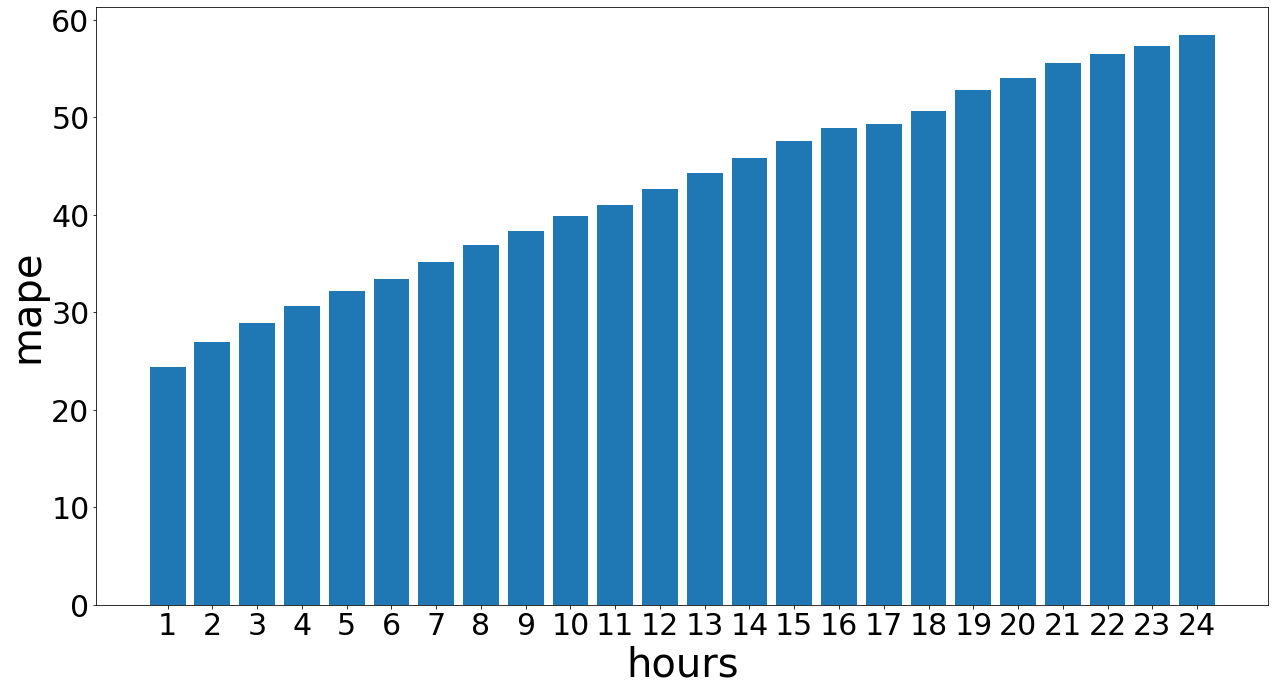

In [95]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,mape_list)
plt.ylabel('mape', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()

0.13377583219119132
0.3275429272292739


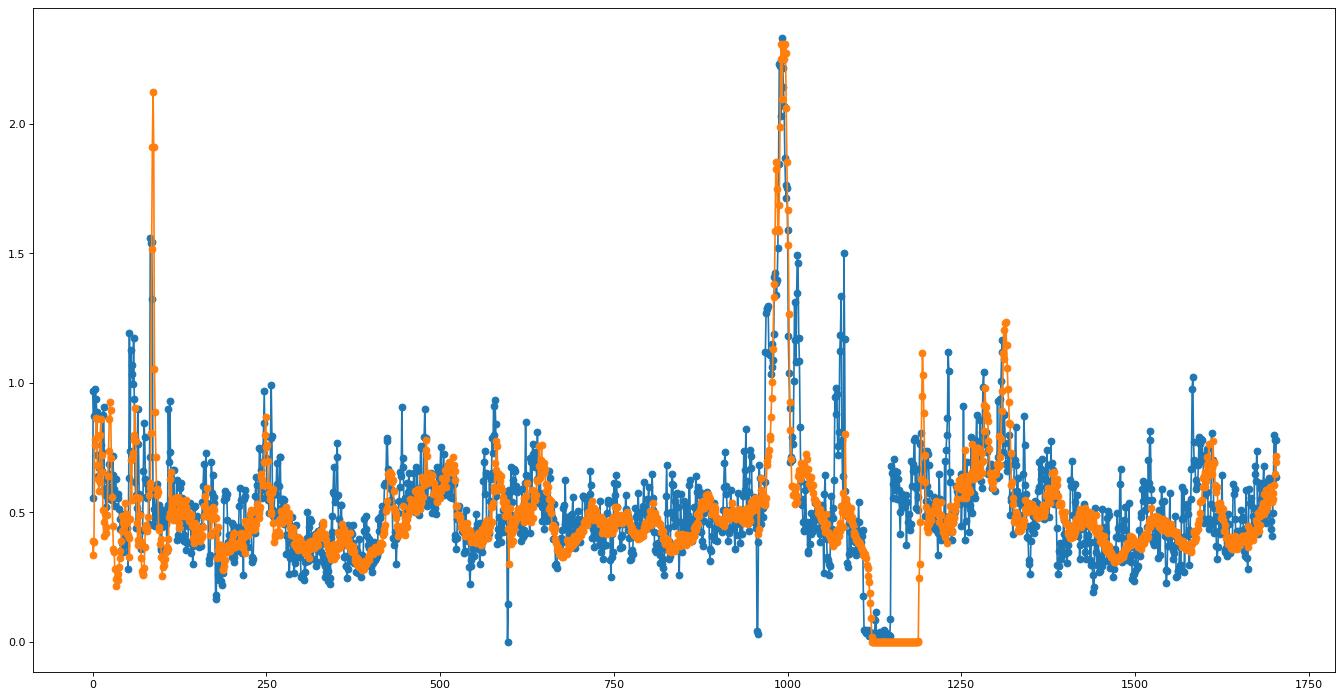

In [172]:
# Horizon wise plot
plt.figure(figsize=(21, 11), dpi= 80, facecolor='w', edgecolor='k')
horizon = 1
yobs = df_obs.iloc[:,horizon] 
ypred = df_pred.iloc[:,horizon]  
print(mean_absolute_error(yobs, ypred))
print(r2_score(yobs, ypred) )
plt.plot(yobs,'o-', label='input')#, linewidth=6)
plt.plot(ypred, 'o-',  label='output')#, linewidth=6)

In [175]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

look_back = 12
shift = 1
df = pd.read_csv('data/2018_1hourdata.csv')
df_total_error = pd.DataFrame(columns=['sites','mae', 'rmse', 'mse'])

sites = ['ALBQ_DENV_out', 'CHIC_ECHI_out', 'EASH_WASH_out', 'EASH_WASH_in', 'AOFA_STAR_out', 'AOFA_WASH_in', 'CHIC_ECHI_in', 'AOFA_WASH_out', 'AOFA_NEWY_in','AOFA_STAR_in', 'CHIC_WASH_in',
'CHIC_WASH_out', 'BOST_NEWY_out', 'ATLA_WASH_in', 'CERN-513_WASH_in', 'AOFA_NEWY_out','CERN-513_WASH_out'] 

# , 'LOND_NEWY_in', 'EASH_ECHI_in', 'EASH_ECHI_out', 'BNL_NEWY_in'

for site in sites:
    print(site)
    X = df[site].values
    size = int(len(X) * 0.8)
    train, test = X[0:size], X[size:len(X)]

    scaler = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))
    train = scaler.transform(train.reshape(-1, 1)).reshape(1, -1)[0]
    test = scaler.transform(test.reshape(-1, 1)).reshape(1, -1)[0]

    x_test, y_test = [], []
    i = 0
    while i + 1 + (2* look_back) <= len(test):
        x_i = test[i: i + look_back]
        y_i = test[i + shift + look_back: i + shift + (2* look_back)]
        x_test.append(x_i)
        y_test.append(y_i)
        i = i + 1
    x_test = np.stack(x_test, axis=0)
    y_test = np.stack(y_test, axis=0)
    
    df_error = pd.DataFrame(columns=['mae', 'rmse', 'mse'])
    for i in range(x_test.shape[0]):
        history = x_test[i]
        model = ARIMA(history, order=(1,0,0)) # (2, 1, 2)
        model_fit = model.fit(disp=0)
        pred = []
        for j in range(12):
            output = model_fit.forecast()[0]
            output = scaler.inverse_transform(output[0].reshape(-1, 1)).reshape(1, -1)
            pred.append(output[0])   

        y_test[i] = scaler.inverse_transform(y_test[i].reshape(-1, 1)).reshape(1, -1)[0]
        mae = mean_absolute_error(y_test[i], pred)
        rmse = np.sqrt(mean_squared_error(y_test[i], pred))
        mse = mean_squared_error(y_test[i], pred)
        df_error = df_error.append({'mae':mae, 'rmse':rmse, 'mse':mse}, ignore_index=True)
    df_total_error = df_total_error.append({'sites':site,'mae':df_error["mae"].mean(), 'rmse':df_error["rmse"].mean(), 'mse':df_error["mse"].mean()}, ignore_index=True)
    
    
    

CERN-513_WASH_out


In [177]:
df_total_error.to_csv('ARIMA_error.csv')